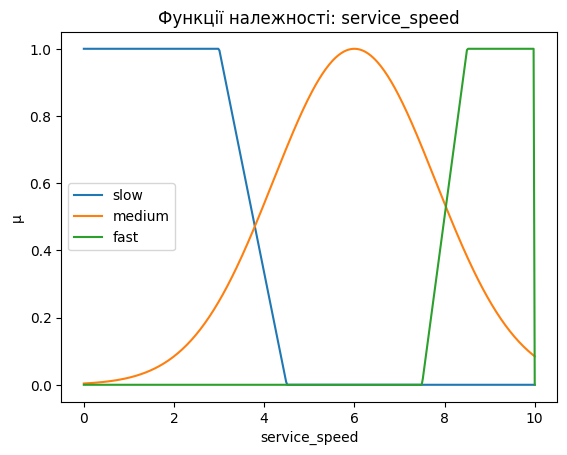

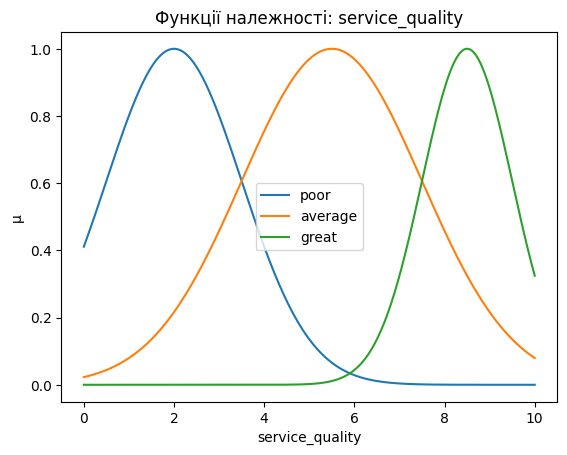

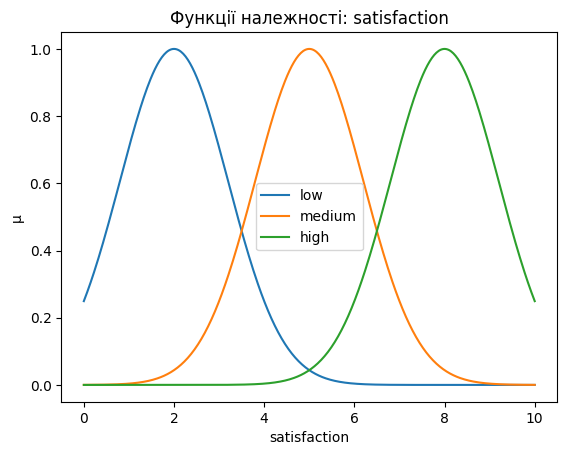

Швидкість=2, Якість=3 → Задоволення=3.35
Швидкість=5, Якість=6 → Задоволення=5.10
Швидкість=8, Якість=9 → Задоволення=6.89


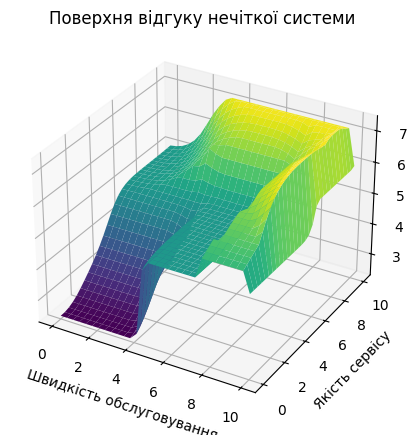

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def trapmf(x, a, b, c, d):
    y = np.zeros_like(x, dtype=float)
    y = np.where((x >= a) & (x <= b), (x - a) / (b - a + 1e-9), y)
    y = np.where((x >= b) & (x <= c), 1.0, y)
    y = np.where((x >= c) & (x <= d), (d - x) / (d - c + 1e-9), y)
    return np.clip(y, 0, 1)


def gaussmf(x, c, s):
    return np.exp(-0.5 * ((x - c) / (s + 1e-9)) ** 2)


class Term:
    def __init__(self, name, kind, params):
        self.name, self.kind, self.params = name, kind, list(params)
    def membership(self, x):
        if self.kind == 'trap':  return trapmf(x, *self.params)
        if self.kind == 'gauss': return gaussmf(x, *self.params)
        raise ValueError("Невідомий тип MF")


class FuzzyVariable:
    def __init__(self, name, universe, terms):
        self.name, self.universe, self.terms = name, universe, terms


class Rule:
    def __init__(self, antecedent, consequent, weight=1.0):
        self.antecedent, self.consequent, self.weight = antecedent, consequent, weight


class MamdaniFIS:
    def __init__(self, inputs, output, rules):
        self.inputs, self.output, self.rules = inputs, output, rules


    def infer(self, x_inputs, resolution=201):
        y0, y1 = self.output.universe
        ys = np.linspace(y0, y1, resolution)
        aggregated = np.zeros_like(ys)
        for rule in self.rules:
            mu_list = []
            for var_name, term_name in rule.antecedent:
                var = self.inputs[var_name]
                mu = var.terms[term_name].membership(np.array([x_inputs[var_name]]))[0]
                mu_list.append(mu)
            firing = min(mu_list) * rule.weight
            mu_out = self.output.terms[rule.consequent].membership(ys)
            aggregated = np.maximum(aggregated, np.minimum(mu_out, firing))
        denom = np.trapezoid(aggregated, ys)
        if denom < 1e-9: return (y0 + y1) / 2
        return np.trapezoid(aggregated * ys, ys) / denom


service_speed = FuzzyVariable("service_speed", (0, 10), {
    "slow":   Term("slow",   "trap", (0, 0, 3, 4.5)),
    "medium": Term("medium", "gauss", (6, 1.8)),
    "fast":   Term("fast",   "trap", (7.5, 8.5, 10, 10))
})


service_quality = FuzzyVariable("service_quality", (0, 10), {
    "poor":   Term("poor",   "gauss", (2, 1.5)),
    "average":Term("average","gauss", (5.5, 2)),
    "great":  Term("great",  "gauss", (8.5, 1)),
})


satisfaction = FuzzyVariable("satisfaction", (0, 10), {
    "low":    Term("low",    "gauss", (2, 1.2)),
    "medium": Term("medium", "gauss", (5, 1.2)),
    "high":   Term("high",   "gauss", (8, 1.2)),
})


rules = [
    Rule([("service_speed","slow"), ("service_quality","poor")], "low"),
    Rule([("service_speed","slow"), ("service_quality","average")], "medium"),
    Rule([("service_speed","medium"), ("service_quality","average")], "medium"),
    Rule([("service_speed","fast"), ("service_quality","great")], "high"),
    Rule([("service_speed","medium"), ("service_quality","great")], "high"),
    Rule([("service_speed","fast"), ("service_quality","average")], "high"),
]


fis = MamdaniFIS({"service_speed":service_speed, "service_quality":service_quality}, satisfaction, rules)


def plot_mfs(var):
    xs = np.linspace(var.universe[0], var.universe[1], 400)
    for name, term in var.terms.items():
        plt.plot(xs, term.membership(xs), label=name)
    plt.title(f"Функції належності: {var.name}")
    plt.xlabel(var.name)
    plt.ylabel("μ")
    plt.legend()
    plt.show()


plot_mfs(service_speed)
plot_mfs(service_quality)
plot_mfs(satisfaction)


tests = [
    {"service_speed": 2, "service_quality": 3},
    {"service_speed": 5, "service_quality": 6},
    {"service_speed": 8, "service_quality": 9},
]


for t in tests:
    res = fis.infer(t)
    print(f"Швидкість={t['service_speed']}, Якість={t['service_quality']} → Задоволення={res:.2f}")


speed_vals = np.linspace(0,10,30)
quality_vals = np.linspace(0,10,30)
Z = np.zeros((len(speed_vals), len(quality_vals)))


for i, sp in enumerate(speed_vals):
    for j, ql in enumerate(quality_vals):
        Z[j,i] = fis.infer({"service_speed":sp, "service_quality":ql})


from mpl_toolkits.mplot3d import Axes3D
X, Y = np.meshgrid(speed_vals, quality_vals)
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel("Швидкість обслуговування")
ax.set_ylabel("Якість сервісу")
ax.set_zlabel("Рівень задоволення")
ax.set_title("Поверхня відгуку нечіткої системи")
plt.show()